The goal for this workbook is to predict the price of an AirBnB listing for a test dataset. We aim to develop model by training on 74,111 records of AirBnb listing with price, property type, amenities provided, location and other attributes. After training our model, we will make prediction based on a test dataset of 25,458 records.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl

from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from imblearn import over_sampling
import seaborn as sns
import datetime
from geopy.geocoders import Nominatim
import math
from os import path
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
pd.set_option('display.max_columns', 500) 

## Loading the data

In [26]:
#import test and train dataset
df_train=pd.read_csv("../Original/train.csv")
df_test=pd.read_csv("../Original/test.csv")

In [3]:
df_train.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [4]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
df_train_ID = df_train['id']
df_test_ID = df_test['id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("id", axis = 1, inplace = True)
df_test.drop("id", axis = 1, inplace = True)

The train data size before dropping Id feature is : (74111, 29) 
The test data size before dropping Id feature is : (25458, 28) 


# Data Processing

## Target Variable
Our first step is to examine the price, which is measured in log_price. We will plot this log_price to make sure it falls under a Normal Distribution


 mu = 4.78 and sigma = 0.72



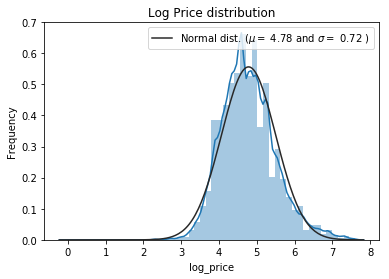

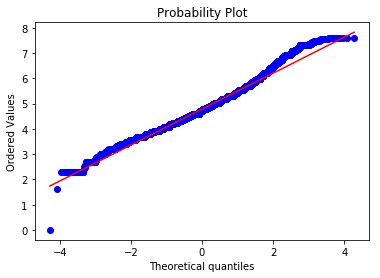

In [5]:
sns.distplot(df_train['log_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['log_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['log_price'], plot=plt)
plt.show()

Looks good! The skew seems correct and the data appears normally distributed

In [6]:
df_train.log_price.describe()

count    74111.000000
mean         4.782069
std          0.717394
min          0.000000
25%          4.317488
50%          4.709530
75%          5.220356
max          7.600402
Name: log_price, dtype: float64

The min value of log_price is 0, meaning the rental price is 1 dollar. This is likely to be wrong. We assume listing price cannot be less than $3 or log(20), because it might be not profitable at all and possibly due to error.

In [10]:
print ('Number of listing less than $3:', df_train[df_train.log_price<=math.log(20)].shape)

Number of listing less than $3: (160, 28)


There are 160 such instances, which accounts for 0.21% of total size of training set. We will remove these instances from our analysis

In [97]:
df_train=df_train[df_train.log_price>math.log(20)]

# Features engineering
## Joining dataset
We will join the train and test dataset together to perform some features engineering. This is to ensure we account for all possible variations in train and test features, and feed them correctly to the machine learning models.

In [11]:
# concatenate train and test dataset in the same dataframe
df_train['label']='train'
df_test['label']='test'
df_concat=pd.concat([df_train,df_test]).reset_index(drop=True)

print("Concated dataframe size is : {}".format(df_concat.shape))

Concated dataframe size is : (99569, 29)


## Missing data
To tackle missing data, first we will look at the proportion of missing data for each variable, and tackle them one by one

In [12]:
# Find the missing data ratio
df_concat_na= (df_concat.isnull().sum() / len(df_concat)) * 100
df_concat_na = df_concat_na.drop(df_concat_na[df_concat_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :df_concat_na})
missing_data.head(20)

,Missing Ratio
log_price,25.568199
host_response_rate,24.711507
review_scores_rating,22.536131
first_review,21.392200
last_review,21.343993
thumbnail_url,11.122940
neighbourhood,9.377417
zipcode,1.292571
bathrooms,0.280208
host_since,0.244052


We will then visualize them

Text(0.5,1,'Percent missing data by feature')

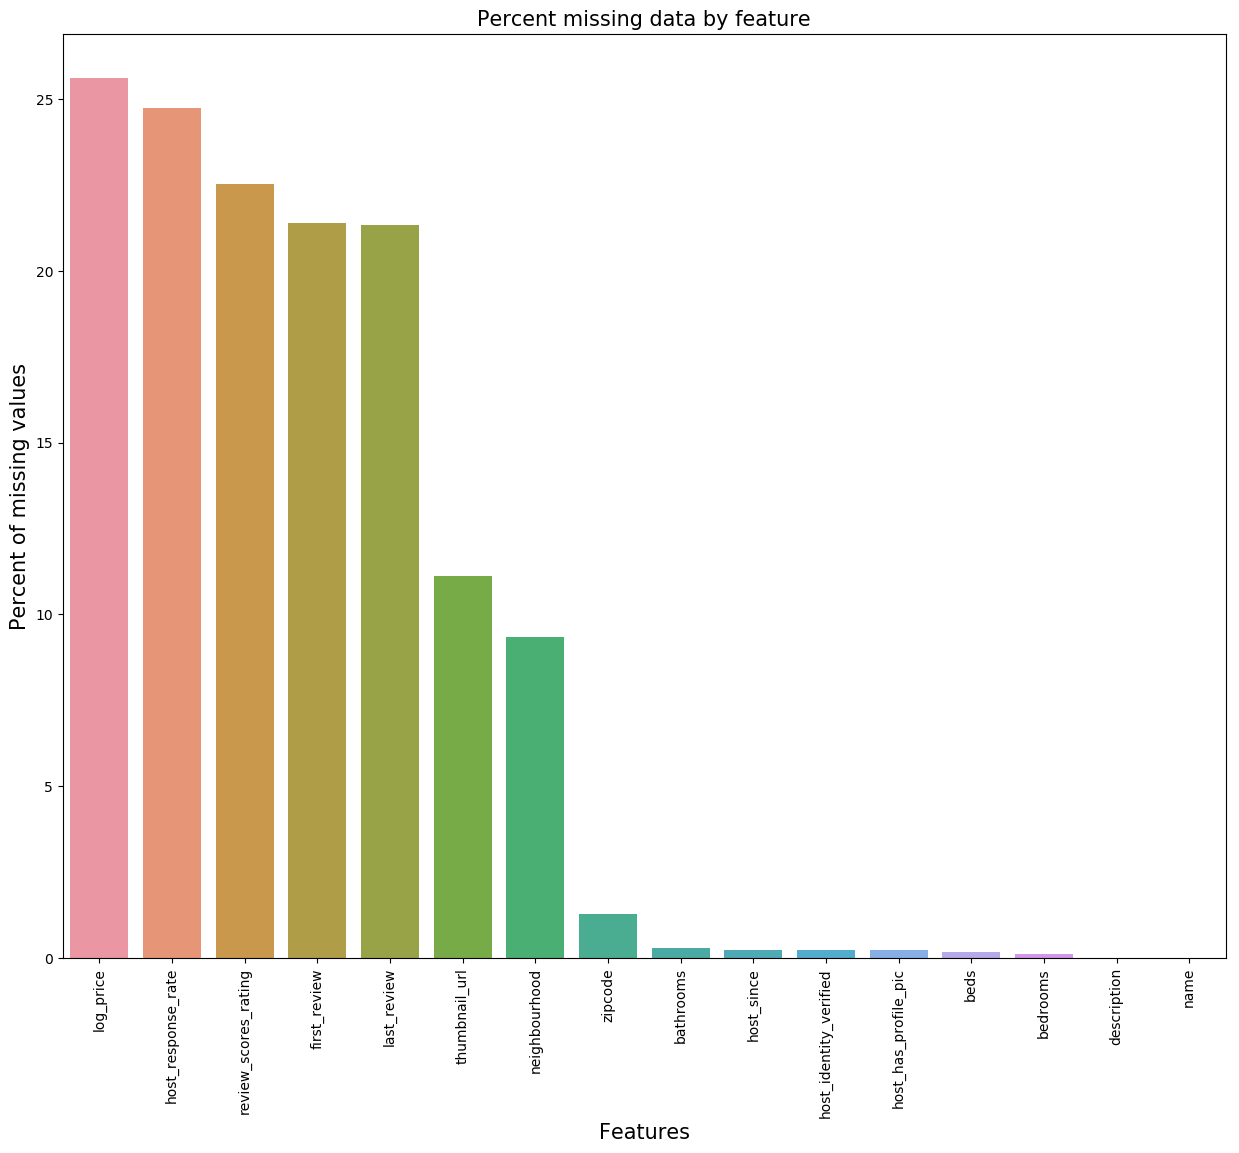

In [100]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=df_concat_na.index, y=df_concat_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

As we can see, log_price is the attribute that is missing the most, this is understandable since it is not present in test data. For the rest of them, we will come up with reasons to discard some of them, and impute values for some.

## Data correlation
We would then look at the pairwise correlation among variables

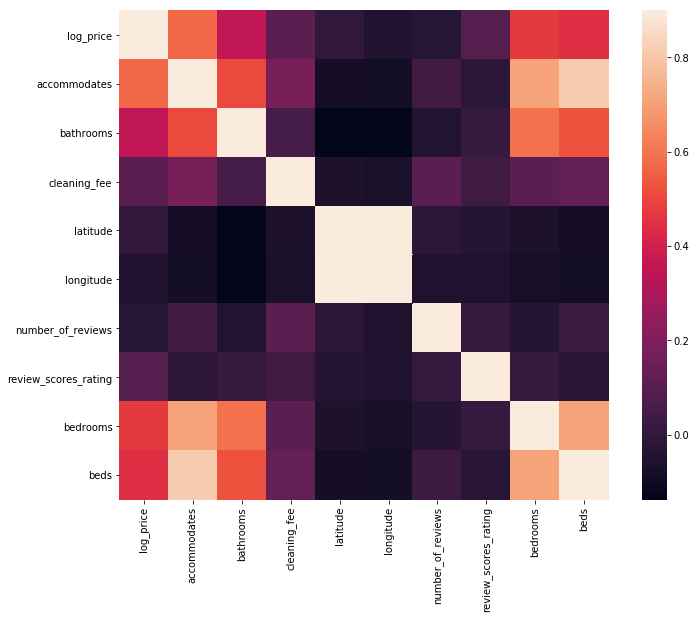

In [13]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

From the correlation map, log_price seems to have strong correlation with accommodates, bedrooms, bathrooms, bed. These are the variables that indicate the size of the room. Longitude and latitude are not directly relevant, thus we need to come up with some variables that indicate the location of the listing.

## Imputing missing values

Because of the importance of the size of the room, it would be crucial to figure out a way to impute these values

In [14]:
#Most listing has 1 bed and 1 bathroom, so we give this default value
df_concat['beds']=df_concat['beds'].fillna(1)
df_concat['bedrooms']=df_concat['bedrooms'].fillna(1)
df_concat['bathrooms']=df_concat['bathrooms'].fillna(1)

#Some listings have 0 bath and 0 bed, we will also give 1 as default value
df_concat['beds']=df_concat['beds'].replace(0,1)
df_concat['bedrooms']=df_concat['bedrooms'].replace(0,1)
df_concat['bathrooms']=df_concat['bathrooms'].replace(0,1)

#Convert these variable to floats
df_concat['bathrooms']=df_concat['bathrooms'].astype(float)
df_concat['beds']=df_concat['beds'].astype(float)
df_concat['accommodates']=df_concat['accommodates'].astype(float)

## Enriching the data

Number of amenities are text string, separated by `,` character. As a result, we can do a simple calculation of number of amenities by counting the number of `,` character plus one. We do not distinguish between one amenity from the other.

In [103]:
df_concat['number_amenities']=df_concat['amenities'].apply(lambda x: x.count(',')+1)

The number of people per bathrooms and people per bed will likely to have some indication on the value of the listing, so we will create some new variables. 

In [15]:
df_concat['person_per_bed']=df_concat['accommodates']/df_concat['beds']
df_concat['person_per_bathroom']=df_concat['accommodates']/df_concat['bathrooms']
df_concat['bath_over_bed']=df_concat['bathrooms']/df_concat['bedrooms']

### Location
Location is an important variable in the price of the listing; as an apartment is closer to city center, it can be priced much higher than outer neigbhbourhood. Currently, we have the following variables related to location: city, neighbourhood, zipcode, long-lat. Among these, city and long-lat have no missing data, while zipcode and neighbourhood have some.

In [16]:
df_concat['city'].value_counts(normalize=True)

NYC        0.435859
LA         0.303418
SF         0.087085
DC         0.075947
Chicago    0.051060
Boston     0.046631
Name: city, dtype: float64

### Distribution of listings in each city

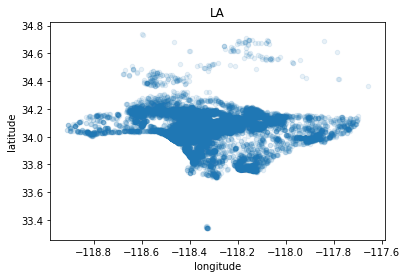

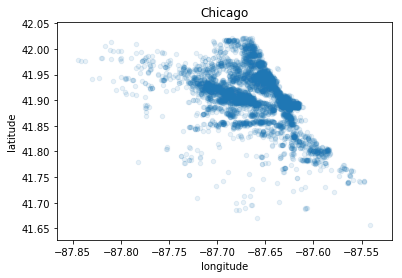

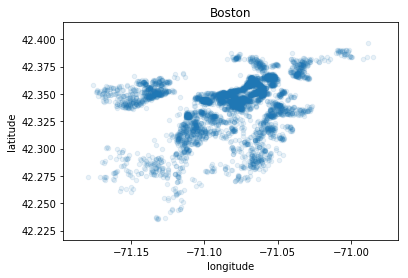

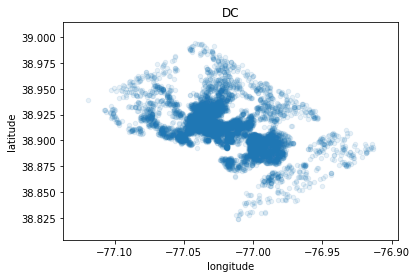

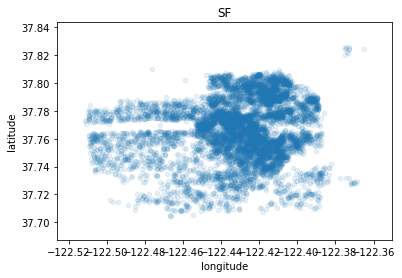

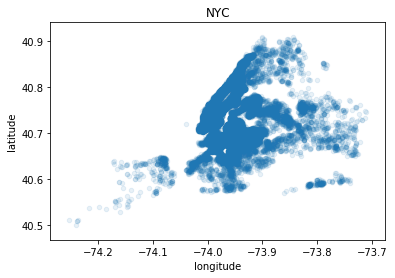

In [17]:
df_concat[df_concat.city=="LA"].plot(kind="scatter", x="longitude", y='latitude', alpha=0.1, title='LA')
df_concat[df_concat.city=="Chicago"].plot(kind="scatter", x="longitude", y='latitude', alpha=0.1, title='Chicago')
df_concat[df_concat.city=="Boston"].plot(kind="scatter", x="longitude", y='latitude',alpha=0.1, title= 'Boston')
df_concat[df_concat.city=="DC"].plot(kind="scatter", x="longitude", y='latitude',alpha=0.1, title= 'DC')
df_concat[df_concat.city=="SF"].plot(kind="scatter", x="longitude", y='latitude',alpha=0.1, title= 'SF')
df_concat[df_concat.city=="NYC"].plot(kind="scatter", x="longitude", y='latitude',alpha=0.1, title= 'NYC')

Almost half of the listing are in New York City. Within each city, listings are scattered over the place. However, city level might be too broad. We need a level that is more specific. We can do this by fixing the zip code and group them into areas.

### Distribution by price

In [107]:
# generate Dollar price for better intuition
df_train['Dollar_price']=np.exp(df_train['log_price'])

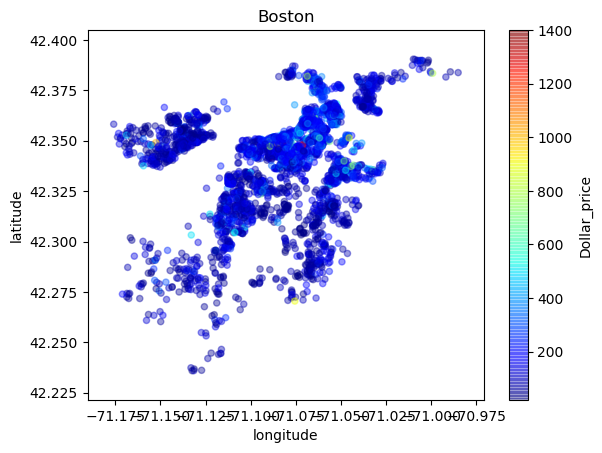

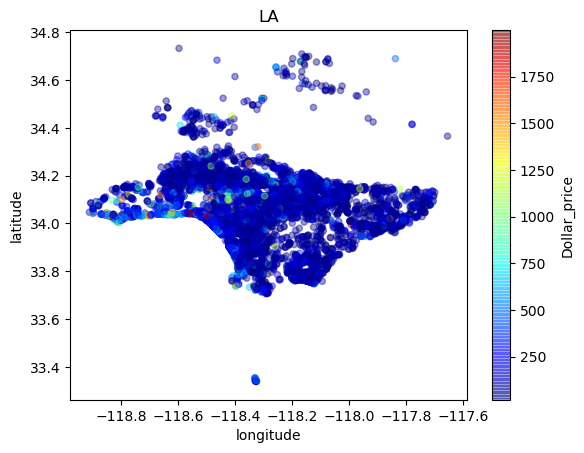

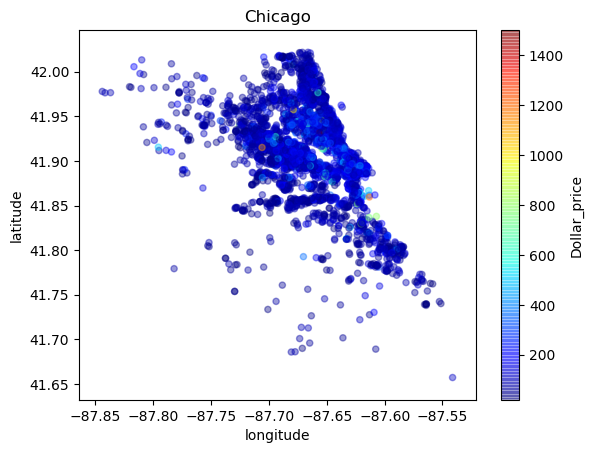

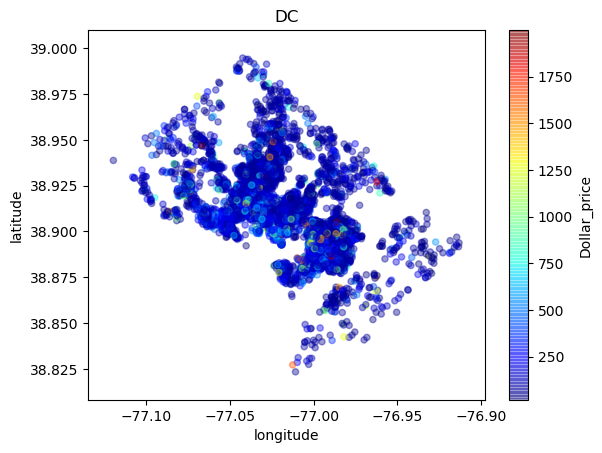

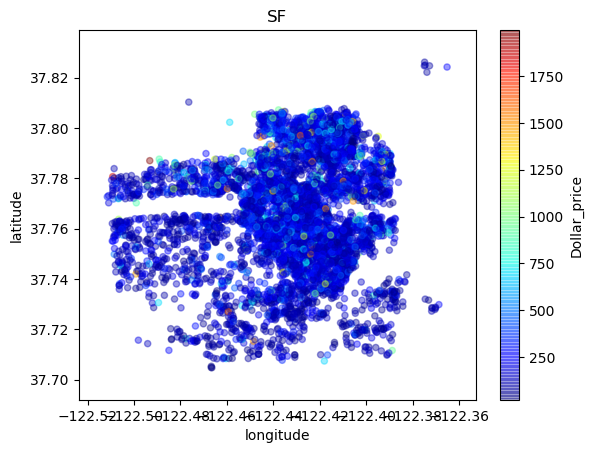

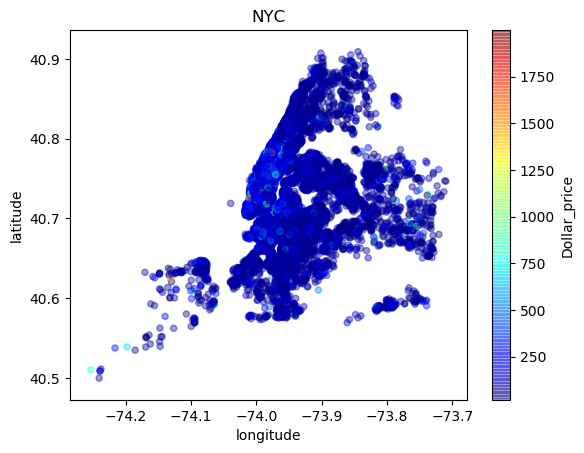

In [108]:
mpl.rcParams.update(mpl.rcParamsDefault)
df_train[df_train.city=="Boston"].plot(kind="scatter",x="longitude", y="latitude",alpha=0.4, c="Dollar_price",cmap=plt.get_cmap("jet"),
colorbar=True, title='Boston')
df_train[df_train.city=="LA"].plot(kind="scatter",x="longitude", y="latitude",alpha=0.4, c="Dollar_price",cmap=plt.get_cmap("jet"),
colorbar=True, title='LA')
df_train[df_train.city=="Chicago"].plot(kind="scatter",x="longitude", y="latitude",alpha=0.4, c="Dollar_price",cmap=plt.get_cmap("jet"),
colorbar=True, title='Chicago')
df_train[df_train.city=="DC"].plot(kind="scatter",x="longitude", y="latitude",alpha=0.4, c="Dollar_price",cmap=plt.get_cmap("jet"),
colorbar=True, title='DC')
df_train[df_train.city=="SF"].plot(kind="scatter",x="longitude", y="latitude",alpha=0.4, c="Dollar_price",cmap=plt.get_cmap("jet"),
colorbar=True, title='SF')
df_train[df_train.city=="NYC"].plot(kind="scatter",x="longitude", y="latitude",alpha=0.4, c="Dollar_price",cmap=plt.get_cmap("jet"),
colorbar=True, title='NYC')

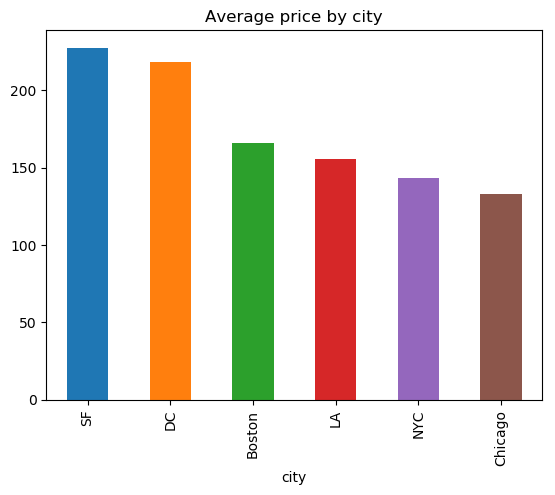

In [109]:
Price_by_city=df_train.groupby('city')['Dollar_price'].mean()
Price_by_city=Price_by_city.sort_values(ascending=False)
plot1=Price_by_city.plot.bar(title='Average price by city')

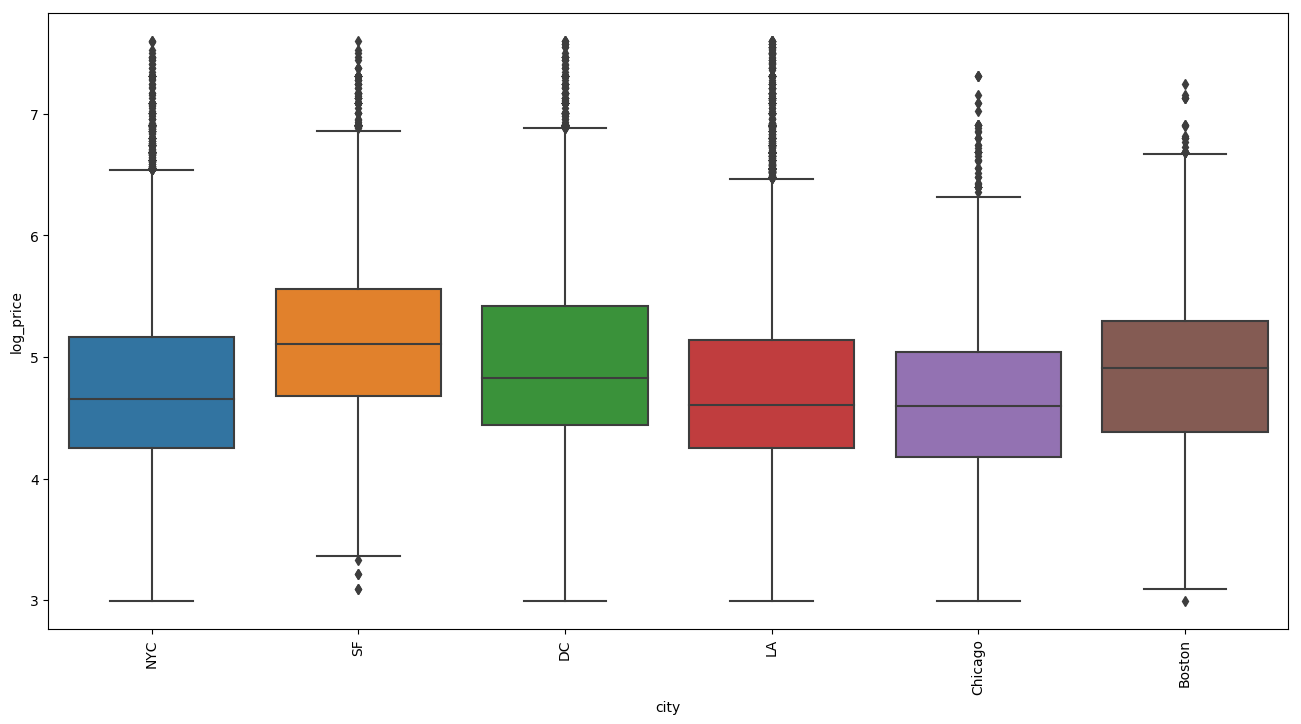

In [110]:
var = 'city'
data = pd.concat([df_train['log_price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="log_price", data=data)
#fig.yaxis.set_major_formatter(tick) 
#fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

There are certainly some outliers in the price in each region. However, we do not fully whether it's safe to remove such cases. As such, we will keep the data for now.

### Fixing zip code
Since the coordinates are present with no missing values, we can use these to derive the zipcode of each listing. These will serve as our location variable and also to join with external dataset.

In [21]:
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()
new_zip=[]
for i in range(len(df_concat)):
    res = search.by_coordinate(df_concat['latitude'][i],df_concat['longitude'][i], radius=5, returns=1)
    try:
        new_zip.append(res[0]['Zipcode'])
    except:
        new_zip.append(0)
df_concat['new_zip']=new_zip


In [22]:
#verify we have no missing zip
df_concat['new_zip'].isnull().sum()
#convert to object
df_concat['new_zip']= df_concat['new_zip'].astype(str)
df_concat['new_zip'].describe()

count     99569
unique      654
top       11211
freq       2404
Name: new_zip, dtype: object

Since zip takes on 654 unique values, some of which might appear once or twice, it does not make sense to use them as is for our model. One approach we could take is to divide zipcodes into groups of zip based on median log price. We would divide zip codes into five groups based on percentile.

In [19]:
for i in (25,50,75,90):
    print(np.percentile(df_train['log_price'],i))

4.31748811353631
4.709530201312334
5.220355825078324
5.703782474656202


In [23]:
test2=pd.DataFrame(df_concat.groupby('new_zip')['log_price'].median())
test2['new_zip']=test2.index
test2['Category']=1
test2.loc[test2.log_price>=4.31,'Category']=2
test2.loc[test2.log_price>=4.709,'Category']=3
test2.loc[test2.log_price>=5.22,'Category']=4
test2.loc[test2.log_price>=5.7,'Category']=5

In [24]:
test2.groupby('Category').count()

,log_price,new_zip
Category,,
1,220,229
2,234,234
3,139,139
4,44,44
5,8,8


Category 1 indicates the lowest group of zip codes based on median log_price. On the other hand, Category 5 is the high-profile, expensive zip codes. Our next step is to add these categories to our concatenated table.

In [116]:
look_up2=test2.set_index('new_zip')['Category'].to_dict()
df_concat['zip_category']=df_concat.new_zip.map(look_up2)

### Add third-party source
Using zipcode, we can also add additional valuable insights by joining with external dataset. We will use Average rent by zip code. We download the Zillow Median Rental price to our local folder.

In [117]:
df_zillow=pd.read_csv("../Original/Zip_MedianRentalPrice_2Bedroom.csv")

In [118]:
# take only zipcode and average rent in January 2018
df_zillow2=df_zillow[['RegionName','2018-01']]
# convert zipcode (region name) into categorical
df_zillow2['RegionName']=df_zillow2['RegionName'].astype(str)
# fix zipcode to contain only 5 character, pad leading zeros in the beginning, such as 4253 --> 04253
df_zillow2['RegionName']=df_zillow2['RegionName'].str.zfill(5)
df_zillow2.head(3)

C:\Users\namhpham\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\namhpham\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,RegionName,2018-01
0,10025,3600.0
1,60657,1850.0
2,10023,5105.0


The "2018-01" column indicates the home rental value in January 2018

In [120]:
# create a lookup table of zip and average rent and join with current dataframe
look_up_rent=df_zillow2.set_index('RegionName')['2018-01'].to_dict()
df_concat['avg_rent']=df_concat.new_zip.map(look_up_rent)

In [121]:
# We still have some missing value for average rent, as a result, we will pad them with the average rent in that city
city = ['NYC','LA','Chicago','Boston','DC','SF']
median=[]
for i in city:
    median += [df_concat[df_concat['city']==i]['avg_rent'].median()]
median

[2843.0, 3295.0, 1700.0, 2700.0, 3200.0, 4370.0]

In [122]:
# Populate the NA with the average rent in respective city
df_concat.loc[df_concat.city=="NYC",'avg_rent'] = df_concat.loc[df_concat.city=="NYC",'avg_rent'].fillna(median[0])
df_concat.loc[df_concat.city=="LA",'avg_rent'] = df_concat.loc[df_concat.city=="LA",'avg_rent'].fillna(median[1])
df_concat.loc[df_concat.city=="Chicago",'avg_rent'] = df_concat.loc[df_concat.city=="Chicago",'avg_rent'].fillna(median[2])
df_concat.loc[df_concat.city=="Boston",'avg_rent'] = df_concat.loc[df_concat.city=="Boston",'avg_rent'].fillna(median[3])
df_concat.loc[df_concat.city=="DC",'avg_rent'] = df_concat.loc[df_concat.city=="DC",'avg_rent'].fillna(median[4])
df_concat.loc[df_concat.city=="SF",'avg_rent'] = df_concat.loc[df_concat.city=="SF",'avg_rent'].fillna(median[5])

In [123]:
# Viewing the dataset after transformation
df_concat.head(3)

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,...,room_type,thumbnail_url,zipcode,number_amenities,person_per_bed,person_per_bathroom,bath_over_bed,new_zip,zip_category,avg_rent
0,3.0,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,1.0,1.0,strict,NYC,True,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,Entire home/apt,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,9,3.000000,3.0,1.000000,11201,3,4151.5
1,7.0,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,3.0,3.0,strict,NYC,True,Enjoy travelling during your stay in Manhattan...,...,Entire home/apt,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,15,2.333333,7.0,0.333333,10019,3,5060.5
2,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1.0,Real Bed,1.0,3.0,moderate,NYC,True,The Oasis comes complete with a full backyard ...,...,Entire home/apt,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,19,1.666667,5.0,1.000000,10037,2,2137.5


## Visualize description
We won't really use description in predicting the price, but it might be worthwhile to look at what the trend in data is.

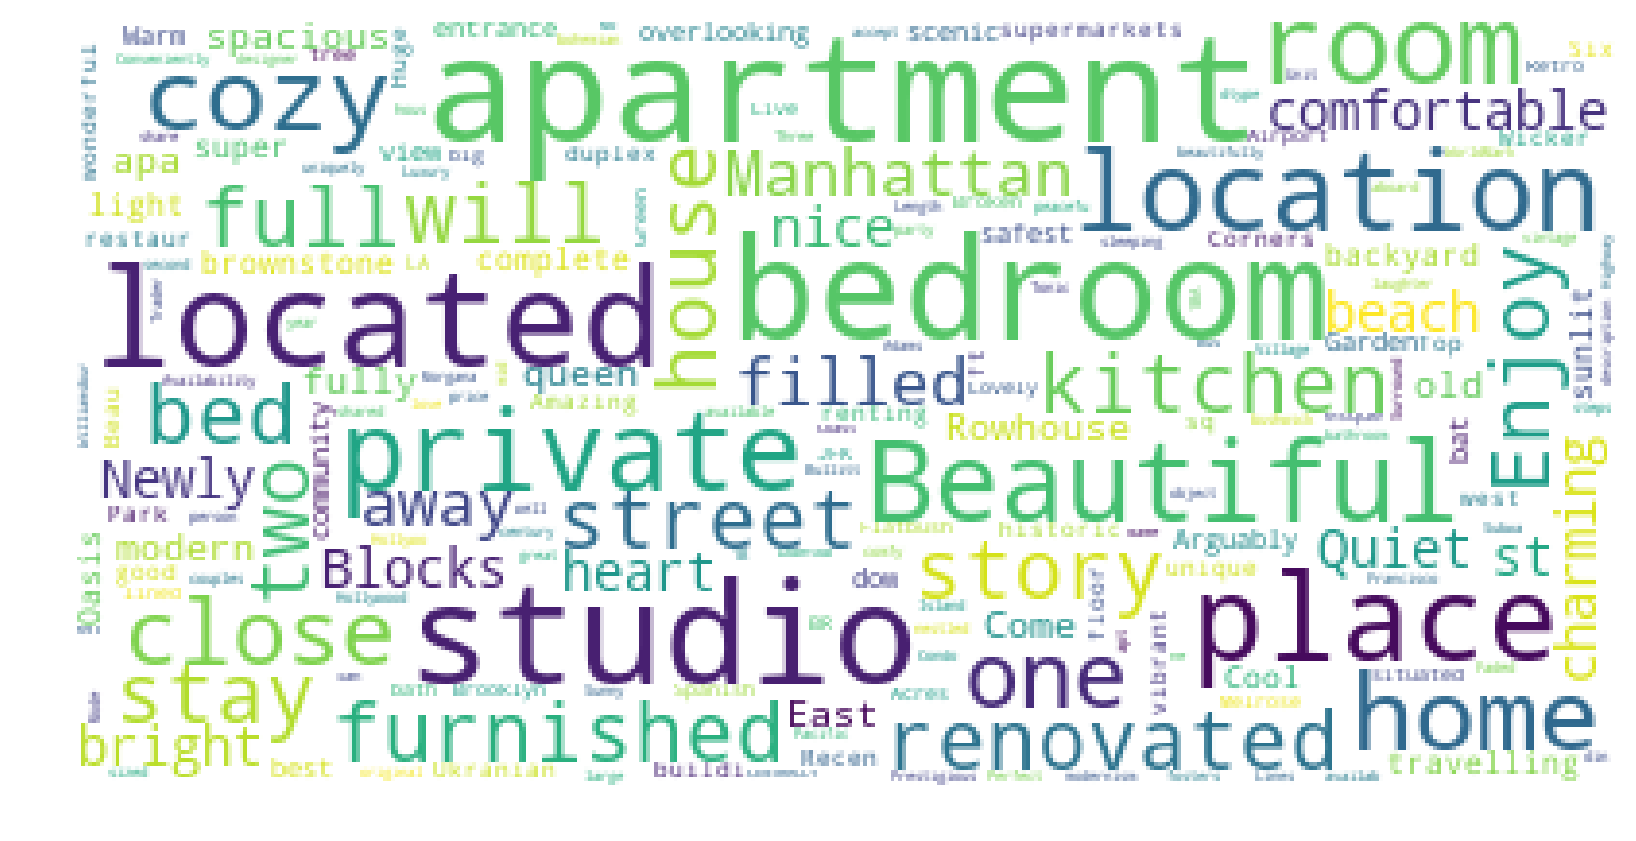

In [124]:
mpl.rcParams['font.size']=20                #10 
mpl.rcParams['savefig.dpi']=200             #72 
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_train['description']))
print(wordcloud)
fig=plt.figure(1)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
plt.clf()
plt.cla()
plt.close()

The description tends to fall into the following categories: Type of room (one bed, two bed), size (cozy, spacious), quality (renovated, nice, modern), location (heart, close, blocks). For future plan, we could extract some of the keywords that indicates a high price listing (such as renovated, nice, newly, beach) and a low price listing (such as studio, cozy) and add a new flag for positive/negative words.

# Building the model

In [125]:
# Retain the following variables 
keep_cols=['label','log_price','bed_type','room_type',
               'accommodates','bathrooms',
               'number_of_reviews', 'beds','bedrooms', 'number_amenities','person_per_bed','person_per_bathroom'
          , 'avg_rent','bath_over_bed','zip_category']

In [126]:
df_concat2=df_concat[keep_cols]

In [127]:
features_df=pd.get_dummies(df_concat2,columns=['room_type','bed_type','zip_category'])
#Get new train and new test set
df_train2=features_df[features_df['label']=='train']
df_test2=features_df[features_df['label']=='test']
#take out log price
y_train=df_train.log_price.values
#df_concat=df_concat.drop(['log_price'],axis=1)
df_train2=df_train2.drop(['label','log_price'],axis=1)
df_test2=df_test2.drop(['label','log_price'],axis=1)

In [129]:
#verify we do not have any null number
df_train2.isnull().sum()

accommodates                 0
bathrooms                    0
number_of_reviews            0
beds                         0
bedrooms                     0
number_amenities             0
person_per_bed               0
person_per_bathroom          0
avg_rent                     0
bath_over_bed                0
room_type_Entire home/apt    0
room_type_Private room       0
room_type_Shared room        0
bed_type_Airbed              0
bed_type_Couch               0
bed_type_Futon               0
bed_type_Pull-out Sofa       0
bed_type_Real Bed            0
zip_category_1               0
zip_category_2               0
zip_category_3               0
zip_category_4               0
zip_category_5               0
dtype: int64

In [130]:
#import libaries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
import lightgbm as lgb

Our plan is to use various regression function, ensemble methods to pass through a function that measure against a cross validation. Our first step is to define a cross-validation function. We choose five folds.

In [131]:
#Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train2.values)
    rmse= np.sqrt(-cross_val_score(model, df_train2.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Lasso:

In [132]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [133]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4306 (0.0033)



### Random Forest:

In [134]:
rf = RandomForestRegressor(n_estimators=200, oob_score=True, n_jobs = -1,random_state=50, max_features = "auto", min_samples_leaf = 100)

In [135]:
score = rmsle_cv(rf)
print("\nRandom forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random forest score: 0.4179 (0.0030)



### ENet

In [136]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [137]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4306 (0.0033)



### Gradient Boosting

In [149]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [150]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.4004 (0.0038)



### LightGBM

In [138]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [139]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.4084 (0.0033)



## Stacking model

In [140]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [151]:
averaged_models = AveragingModels(models = (ENet, model_lgb, lasso, rf, GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.4097 (0.0033)



## Final Training and Prediction

In [143]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Averaged Model

In [152]:
averaged_models.fit(df_train2.values, y_train)
averaged_models_pred = averaged_models.predict(df_train2.values)
print(rmsle(y_train, averaged_models_pred))

0.40438064205473273


### LightGBM

In [144]:
model_lgb.fit(df_train2.values, y_train)
model_lgb_train_pred = model_lgb.predict(df_train2.values)
print(rmsle(y_train, model_lgb_train_pred))

0.4059015373639801


### Stacked model

In [145]:
averaged_models.fit(df_train2.values, y_train)
averaged_models_train_pred=averaged_models.predict(df_train2.values)
print(rmsle(y_train,averaged_models_train_pred))

0.4124030644974333


We will go with LightGBM model

In [154]:
test_pred=averaged_models.predict(df_test2.values)

### Submission

In [155]:
sub = pd.DataFrame()
sub['id']= df_test_ID
sub['log_price']=model_lgb_test_pred

In [156]:
sub.head(5)

,id,log_price
0,3895911,4.691088
1,9710289,4.987255
2,9051635,4.312100
3,708374,4.838028
4,626296,5.443215


In [ ]:
#sub.to_csv('submission_5-1.csv', index=False)